## Scripts for the generation of some figures

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import data_utils as dt
import turnover_corr_utils as ut
import turnover_measures as ms
import stat_utils as st
import pickle
from scipy.stats import norm, spearmanr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

hiv_data_dir = '../data/hiv_msa/'
abr_data_dir = '../data/abr_fams/'

sns.set_theme(style="white")

### Sample sizes

In [3]:
n_uniques_seqs_hiv, n_reads_hiv = [], []
n_uniques_seqs_bcr, n_reads_bcr = [], []
for pat in range(1,10):
    pat = str(pat)
    hiv_frame = dt.read_hiv_msa_fasta(hiv_data_dir+'pat'+pat+'_hiv_msa.fasta')
    fams = dt.import_fam_frame_pat(abr_data_dir, pat, keep_seq=True)
    abr_time_frame, abr_times = dt.build_fam_timeframe(fams, False)
    for t in range(max(hiv_frame['time'])):
        n_uniques_seqs_hiv.append(len(hiv_frame[hiv_frame['time']==t]))        
        n_reads_hiv.append(np.sum(hiv_frame[hiv_frame['time']==t]['counts']))
        n_uniques_seqs_bcr.append(len(abr_time_frame[abr_time_frame['time']==t]))
        n_reads_bcr.append(np.sum(abr_time_frame[abr_time_frame['time']==t]['counts']))

In [4]:
np.mean(n_uniques_seqs_hiv), np.mean(n_reads_hiv), np.mean(n_uniques_seqs_bcr), np.mean(n_reads_bcr)

(1037.4301075268818, 25472.204301075268, 12679.462365591398, 213764.6559139785)

### Plots related with turnover measures

In [2]:
def norm_traj(traj):
    return (np.array(traj) - min(traj))/(max(traj) - min(traj))

def rank(array, norm=True):
    temp = np.argsort(array)
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    if norm:
        ranks = ranks / (len(array)-1)
    return ranks

In [4]:
hiv_measures_class = [
    ms.hiv_turnover_freq(),
    ms.hiv_turnover_count(),
    ms.hiv_turnover_synratio_freq(),
    ms.hiv_turnover_synratio_count(),
    ms.hiv_nseq(),
    ms.delta_times()
]
hiv_labels = [m.short_label() for m in hiv_measures_class]

abr_measures_class = [
    ms.abr_snp_turnover_freq(),
    ms.abr_snp_turnover_count(),
    ms.abr_lin_turnover_freq(),
    ms.abr_lin_turnover_count(),
    ms.abr_turnover_count_large(),
    ms.abr_turnover_count_small(),
    ms.abr_nseq(),
    ms.delta_times()
]
abr_labels = [m.short_label() for m in abr_measures_class]

In [5]:
f = open('out_data/abr_measures.pickle', 'rb')
abr_measures = pickle.load(f)
f.close()
f = open('out_data/abr_labels.pickle', 'rb')
#abr_labels = pickle.load(f)
f.close()
f = open('out_data/hiv_measures.pickle', 'rb')
hiv_measures = pickle.load(f)
f.close()
f = open('out_data/hiv_labels.pickle', 'rb')
#hiv_labels = pickle.load(f)
f.close()

In [7]:
stds = st.compute_corrcoef_std(19, R=5000)

In [10]:
shift = 0
rhos, pvals = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, shift)
kss, kspval_sync, av_rho_sync = st.compute_KS_stat(rhos, False)

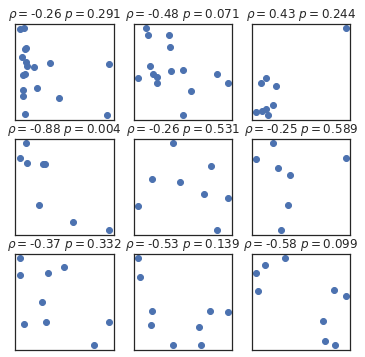

In [12]:
mhiv_i, mabr_i = 1,1
print()
fig, axs = plt.subplots(3,3,figsize=(6,6))

for i in range(3):
    for j in range(3):
        pat = str(j + 3*i + 1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        r,p = spearmanr(hiv_measures[pat][mhiv_i], abr_measures[pat][mabr_i])
        axs[i][j].set_title(r'$\rho =$%3.2f $p=$%4.3f'%(r,p))
        axs[i][j].scatter(hiv_measures[pat][mhiv_i], abr_measures[pat][mabr_i])
        
#plt.savefig('plots/corr_exe_'+str(mhiv_i)+'_'+str(mabr_i)+'.svg')

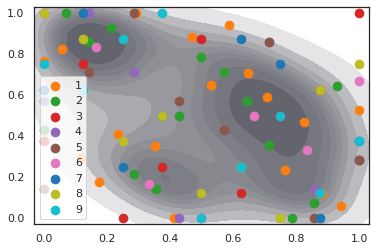

In [48]:
color_patients = list(cm.get_cmap('tab10').colors)
color_patients[7] = color_patients[0]
colors = [(1,1,1), np.array([0.9,0.9,1])*0.4] # first color is black, last is red
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=20)

plt.xlim(-0.03,1.03)
plt.ylim(-0.03,1.03)

mhiv_i, mabr_i = 1,2
all_x, all_y = np.array([]), np.array([])
for i in range(3):
    for j in range(3):
        pat = str(j + 3*i + 1)
        all_x = np.append(all_x, rank(hiv_measures[pat][mhiv_i]))
        all_y = np.append(all_y, rank(abr_measures[pat][mabr_i]))
        
sns.kdeplot(x=all_x, y=all_y, cmap=cmap, shade=True, bw_method=0.5, clip=[[-0.03,1.03],[-0.03,1.03]], levels=10)

for i in range(3):
    for j in range(3):
        pat = str(j + 3*i + 1)
        r,p = st.spearmanr(hiv_measures[pat][mhiv_i], abr_measures[pat][mabr_i])
        plt.scatter(rank(hiv_measures[pat][mhiv_i]), rank(abr_measures[pat][mabr_i]), label=pat, s=75, color=color_patients[int(pat)])
        
plt.legend()

#plt.savefig('plots/scatter_all_'+str(mhiv_i)+'_'+str(mabr_i)+'_shift:'+str(shift)+'.svg')

In [49]:
st.spearmanr(all_x, all_y)

SpearmanrResult(correlation=-0.3041566530404074, pvalue=0.0032019543904070855)

hiv_turn_count abr_turn_large_count


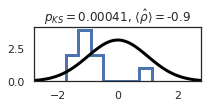

In [50]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(3,1))
plt.plot(x, norm.pdf(x)*8, lw=3, c='black')

plt.ylim(0,4.2)
plt.xlim(-2.8,2.8)
print(hiv_labels[mhiv_i], abr_labels[mabr_i])
h=plt.hist(rhos[:,mhiv_i,mabr_i], bins=7, lw=3,
         label=hiv_labels[mhiv_i]+' vs '+abr_labels[mabr_i], histtype='step')

plt.title(r'$p_{KS}=$%.2g, $\langle \hat\rho \rangle=$%.2g' %(kspval_sync[mhiv_i,mabr_i], rhos[:,mhiv_i,mabr_i].mean()))
#plt.tight_layout()
#plt.savefig('plots/ks_samples_'+str(mhiv_i)+'_'+str(mabr_i)+'_shift:'+str(shift)+'.svg')

### Correlations with time shift

In [20]:
rhos, pvals = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, 0)
kss, kspval_sync, av_rho_sync = st.compute_KS_stat(rhos, False)
rhos, pvals = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, -1)
kss, kspval_hiv1, av_rho_hiv1 = st.compute_KS_stat(rhos, False)
rhos, pvals = st.compute_rescaled_corr(hiv_measures, abr_measures, False, stds, 1)
kss, kspval_abr1, av_rho_abr1 = st.compute_KS_stat(rhos, False)

In [21]:
sign_pair_sync = [[1,3],[1,4],[2,4]]
sign_pair_abr1 = [[3,4],[2,1],[2,3],[2,4],[0,3],[0,4]]

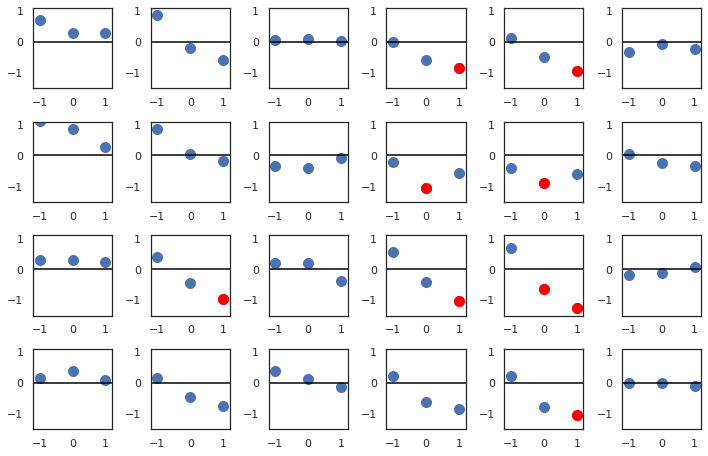

In [30]:
fig, axs = plt.subplots(4,6,figsize=(10,6.5))

x = [-1,0,1]
ylim = [-1.5,1.1]
xlim = [-1.2,1.2]

for mhiv_i in range(4):
    for mabr_i in range(6):
        y = [av_rho_hiv1[mhiv_i, mabr_i], av_rho_sync[mhiv_i, mabr_i], av_rho_abr1[mhiv_i, mabr_i]]
        ax = axs[mhiv_i][mabr_i]
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.scatter(x,y, s=100)
        ax.plot(xlim,[0,0], color='black')
        
        if [mhiv_i, mabr_i] in sign_pair_sync:
            ax.scatter([0], [av_rho_sync[mhiv_i, mabr_i]], color='red', s=100)

        if [mhiv_i, mabr_i] in sign_pair_abr1:
            ax.scatter([1], [av_rho_abr1[mhiv_i, mabr_i]], color='red', s=100)
            
plt.tight_layout()
plt.savefig('plots/ks_time_shift.svg')